In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("ex_data_v2.csv")
# about 1K duplicate rows - will remove them
df = df.drop_duplicates().reset_index(drop=True)
df

,source_port,dest_port,nat_source_port,nat_dest_port,bytes,bytes_sent,bytes_received,packets,time_elapsed_sec,timestamp,ts_ret_a,timestamp_relative,packets_sent,packets_received
0,57222,53,54587,53,177,94,83,2,30,1552573800000,0,0,1,1
1,56258,3389,56258,3389,4768,1600,3168,19,17,1552573800720,720,30,10,9
2,6881,50321,43265,50321,238,118,120,2,1199,1552573801128,1128,47,1,1
3,50553,3389,50553,3389,3327,1438,1889,15,17,1552573829904,29904,1246,8,7
4,50002,443,45848,443,25358,6778,18580,31,16,1552573830312,30312,1263,13,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76032,57936,443,57936,443,18738,1904,16834,33,17,1552695184632,95598072,3983253,17,16
76033,45987,123,19536,123,184,94,90,2,30,1552695185040,95598480,3983270,1,1
76034,64169,53,57112,53,212,102,110,2,30,1552695185760,95599200,3983300,1,1
76035,57344,53,65328,53,177,94,83,2,30,1552695186480,95599920,3983330,1,1


In [2]:
# no NA s in dataset
df.isna().sum()

source_port           0
dest_port             0
nat_source_port       0
nat_dest_port         0
bytes                 0
bytes_sent            0
bytes_received        0
packets               0
time_elapsed_sec      0
timestamp             0
ts_ret_a              0
timestamp_relative    0
packets_sent          0
packets_received      0
dtype: int64

In [3]:
#known anomaly (only one exists in dataset)
anomaly = df.loc[df.timestamp == 1552695187200]

#looking at all rows with source_port == anomaly source_port: 
#seems like anomaly row is exact duplicate of row 61494 apart from timestamp and packets wich is 10X
df.loc[df.source_port == anomaly.source_port.iloc[0]]

,source_port,dest_port,nat_source_port,nat_dest_port,bytes,bytes_sent,bytes_received,packets,time_elapsed_sec,timestamp,ts_ret_a,timestamp_relative,packets_sent,packets_received
60191,8430,53,21349,53,80361,77433,2928,946,89,1552668925536,95125536,3963564,930,16
60540,8430,53,61822,53,239209,233954,5255,2850,88,1552669400640,95600640,3983360,2822,28
75687,8430,53,21349,53,80361,77433,2928,946,89,1552694712096,95125536,3963564,930,16
76036,8430,53,61822,53,239209,233954,5255,28500,88,1552695187200,95600640,3983360,2822,28


In [4]:
#findings from the entire dataset:

# 1. dest_port and nat_dest_port are not equall 43% of the time
print("1: ", np.sum(df.dest_port != df.nat_dest_port)/df.shape[0])

# 2. percentage of unique source_port is 29%
print("2: ", len(df.source_port.unique())/df.shape[0])

# 3. percentage of unique nat_source_port is 37%
print("3: ", len(df.nat_source_port.unique())/df.shape[0])

# 4. bytes == bytes_sent + bytes_received 
print("4: ", (df.bytes == df.bytes_sent + df.bytes_received).unique())

# 5. easy candidate for anomaly detection: packets == packets_sent + packets_received except for anomaly row (last row)
print("5: ", "for regular data: ", (df.packets[:-1] - df.packets_sent[:-1] - df.packets_received[:-1]).unique())
print("for anomaly: ", (anomaly.packets - anomaly.packets_sent - anomaly.packets_received).iloc[0])

# 6. check for if timestamps are monotonic:
print("6: ", "timestamp monotonic: ", df.timestamp.is_monotonic, ", ts_ret_a monotonic: ", \
      df.ts_ret_a.is_monotonic, ", timestamp_relative monotonic: ",df.timestamp_relative.is_monotonic)
# so dataset is sorted by timestamp but sometimes a "task" takes longer to finish than the next task...(?) 

# 7. for some reason, for 1.2% of the time, derivative of timestamp_relative != previous time_elapsed_sec
print("7: ", len(np.where((np.diff(df.timestamp_relative) != df.time_elapsed_sec.iloc[:-1]))[0])/df.shape[0])

# 8. if source_port is 0 than 'dest_port', 'nat_source_port', 'nat_dest_port' and time_elapsed_sec also 0
print("8: ", df.loc[df.source_port==0].time_elapsed_sec.unique())

1:  0.4264108263082447
2:  0.2988545050435972
3:  0.38339229585596485
4:  [ True]
5:  for regular data:  [0]
for anomaly:  25650
6:  timestamp monotonic:  True , ts_ret_a monotonic:  False , timestamp_relative monotonic:  False
7:  0.012585977879190394
8:  [0]


In [5]:
# some rows are duplicates but then they appear with timestamp difference of exactly 25786560 !!!
def find_timestamp_diff_between_duplicates(
    df, cols_to_ignore=['timestamp', 'packets']):
    subset = df.columns.tolist()
    for elem in cols_to_ignore:
        subset.remove(elem)
    df1 = df.iloc[np.where(df.duplicated(subset=subset, keep=False))]#.sort_values(['source_port', 'nat_source_port'])

    df1 = df1.drop(cols_to_ignore, axis=1)
    duplicate_indexes = df1.groupby(list(df1)).apply(lambda x: list(x.index)).tolist()
    
    all_timestamp_diffs = []
    for dup in duplicate_indexes:
        all_timestamp_diffs.append(np.diff(df.loc[dup,'timestamp'].values))

    print("unique timestamp gaps between duplicate rows: ", np.unique(all_timestamp_diffs))
    return all_timestamp_diffs, duplicate_indexes

_, duplicate_indexes = find_timestamp_diff_between_duplicates(df)

unique timestamp gaps between duplicate rows:  [25786560]


In [6]:
# only one place where derivative of timestamp != derivative of ts_ret_a.
# safe to assume it is a measuring error (?)
df.iloc[np.where(np.diff(df.timestamp) != np.diff(df.ts_ret_a))]

,source_port,dest_port,nat_source_port,nat_dest_port,bytes,bytes_sent,bytes_received,packets,time_elapsed_sec,timestamp,ts_ret_a,timestamp_relative,packets_sent,packets_received
64568,54867,445,0,0,70,70,0,1,0,1552677340944,103540944,4314206,1,0


In [7]:
# can learn that usually number of packets is small (median for sent/recieved is 1) with sometimes extreme cases that are ok
df.describe()

,source_port,dest_port,nat_source_port,nat_dest_port,bytes,bytes_sent,bytes_received,packets,time_elapsed_sec,timestamp,ts_ret_a,timestamp_relative,packets_sent,packets_received
count,76037.000000,76037.000000,76037.000000,76037.000000,7.603700e+04,7.603700e+04,7.603700e+04,7.603700e+04,76037.000000,7.603700e+04,7.603700e+04,7.603700e+04,76037.000000,76037.000000
mean,49251.553388,10706.961414,19436.452582,2777.513566,1.001169e+05,2.252046e+04,7.759642e+04,1.094406e+02,66.518774,1.552633e+12,5.498481e+07,2.291034e+06,43.657982,65.445283
std,15171.422250,18640.028094,21965.646521,9890.641392,5.464990e+06,3.637228e+06,2.462892e+06,5.331046e+03,302.702918,3.580575e+07,3.082948e+07,1.284562e+06,3198.028280,2416.243946
min,0.000000,0.000000,0.000000,0.000000,6.000000e+01,6.000000e+01,0.000000e+00,1.000000e+00,0.000000,1.552574e+12,0.000000e+00,0.000000e+00,1.000000,0.000000
25%,49167.000000,80.000000,0.000000,0.000000,7.000000e+01,6.600000e+01,0.000000e+00,1.000000e+00,0.000000,1.552602e+12,2.819426e+07,1.174761e+06,1.000000,0.000000
50%,53514.000000,445.000000,9366.000000,53.000000,1.720000e+02,9.000000e+01,8.000000e+01,2.000000e+00,15.000000,1.552630e+12,5.645767e+07,2.352403e+06,1.000000,1.000000
75%,58022.000000,15503.000000,38554.000000,443.000000,7.550000e+02,2.340000e+02,4.700000e+02,6.000000e+00,30.000000,1.552664e+12,8.404205e+07,3.501752e+06,3.000000,2.000000
max,65534.000000,65535.000000,65535.000000,65535.000000,1.269359e+09,9.484772e+08,3.208818e+08,1.036116e+06,10824.000000,1.552695e+12,1.035409e+08,4.314206e+06,747520.000000,327208.000000


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
def box_plot(df, selection = ['bytes_sent', 'bytes_received', 'packets_sent', 'packets_received', 'time_elapsed_sec']):

    fig, axes = plt.subplots(2, 1+len(selection)//2, figsize=(20, len(selection)*2))
    for i, col in enumerate(selection):
        ax = sns.boxplot(y=df.loc[:, col], ax=axes.flatten()[i])
        ax.set_ylim(df[col].min(), df[col].max())
        ax.set_ylabel(col + ' / Unit')
    plt.show()
    return
box_plot(df)

C:\Users\GABRIEVA\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<Figure size 2000x1000 with 6 Axes>

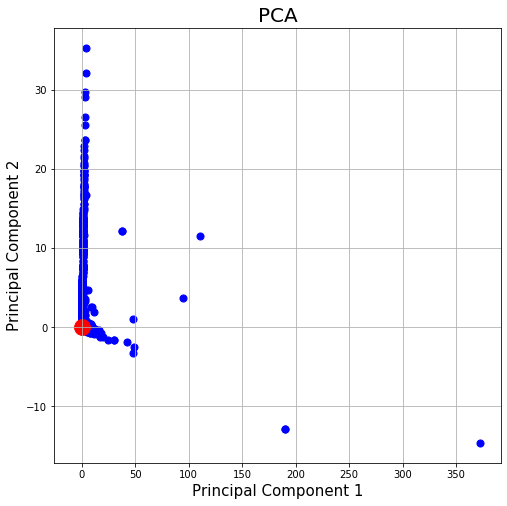

In [9]:
# doing PCA on entire dataset shows that: 
# packets and bytes have a range with very few outliers that are known to not be anomalies!
# red dot shows the anomaly
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

def PCA_on_data(df, features = ['bytes_sent', 'bytes_received', 'time_elapsed_sec', 'packets_sent', 'packets_received']):
    # Separating out the features
    x = df.loc[:, features].values
    # Standardizing the features
    x = StandardScaler().fit_transform(x)

    pca = PCA(n_components=2)  #3
    principalComponents = pca.fit_transform(x)
    finalDf = pd.DataFrame(data = principalComponents, columns = ['p1', 'p2']) #, 'p3'])

    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    #ax = fig.add_subplot(111, projection='3d') 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    #ax.set_zlabel('Principal Component 3', fontsize = 15)
    ax.set_title('PCA', fontsize = 20)
    ax.scatter(finalDf.p1.iloc[:-1], finalDf.p2.iloc[:-1], s = 50, c='b')
    ax.scatter(finalDf.p1.iloc[-1], finalDf.p2.iloc[-1], s = 250, c='r')
    ax.grid()
    
    return finalDf
    

_ = PCA_on_data(df)

# From here I will use only the rows with dest_port = 53 (DNS port)

In [10]:
df_dns = df.loc[df.dest_port ==  anomaly.dest_port.iloc[0]].copy().reset_index()
df_dns

,index,source_port,dest_port,nat_source_port,nat_dest_port,bytes,bytes_sent,bytes_received,packets,time_elapsed_sec,timestamp,ts_ret_a,timestamp_relative,packets_sent,packets_received
0,0,57222,53,54587,53,177,94,83,2,30,1552573800000,0,0,1,1
1,13,55597,53,45448,53,168,86,82,2,30,1552573837416,37416,1559,1,1
2,16,1939,53,33288,53,210,78,132,2,30,1552573840608,40608,1692,1,1
3,17,50281,53,33175,53,195,102,93,2,30,1552573841328,41328,1722,1,1
4,18,57222,53,51448,53,177,94,83,2,30,1552573842048,42048,1752,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17848,75988,39166,53,0,0,82,82,0,1,31,1552695162288,95575728,3982322,1,0
17849,75989,64180,53,16774,53,176,90,86,2,31,1552695163032,95576472,3982353,1,1
17850,76034,64169,53,57112,53,212,102,110,2,30,1552695185760,95599200,3983300,1,1
17851,76035,57344,53,65328,53,177,94,83,2,30,1552695186480,95599920,3983330,1,1


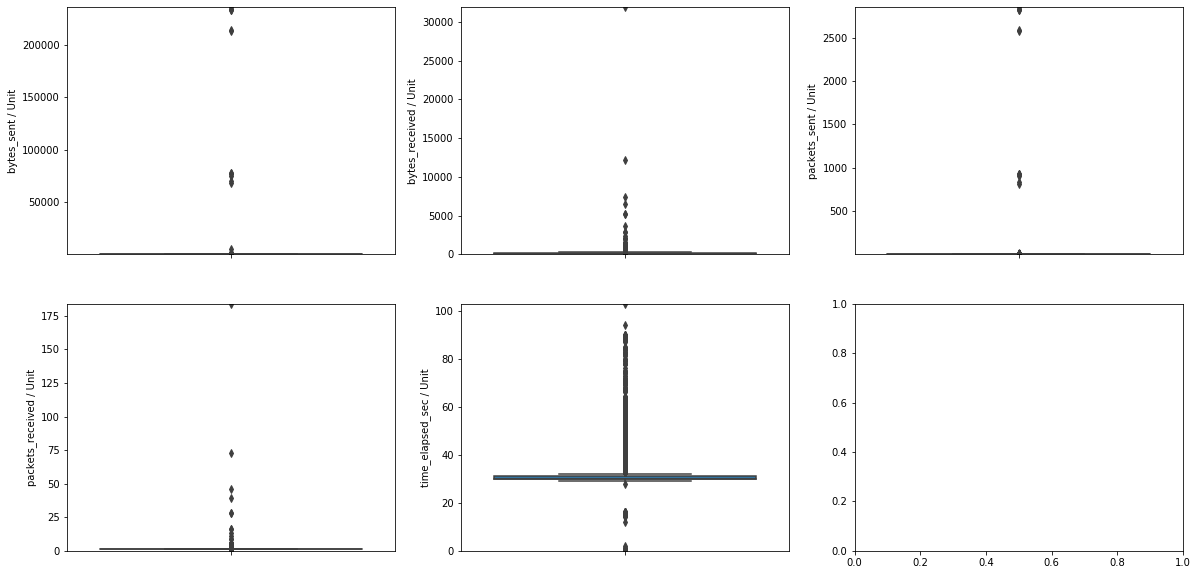

In [11]:
box_plot(df_dns)

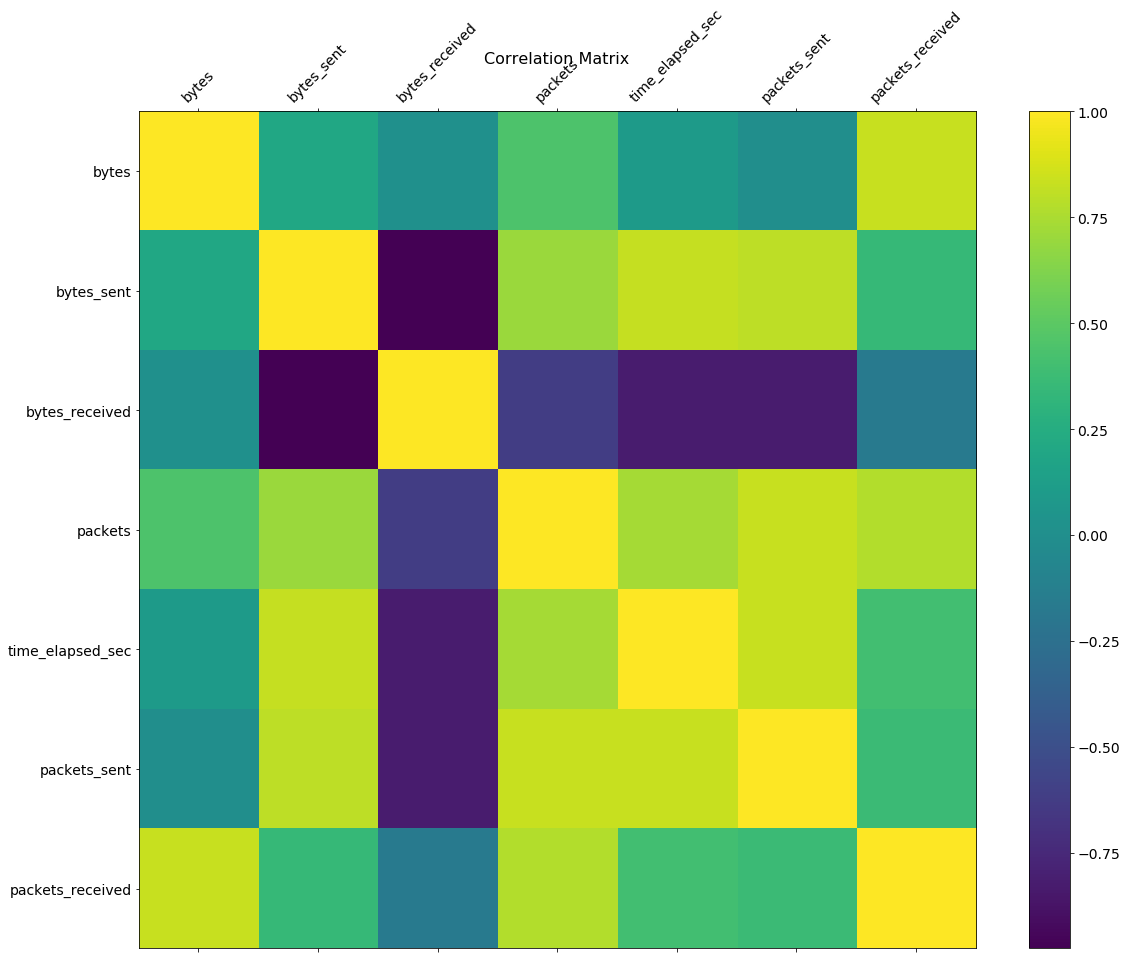

In [12]:
# obvious correlations between bytes and packets. interesting correlation between time_elapsed and bytes/packets sent
f = plt.figure(figsize=(19, 15))
df_to_corr = df_dns.loc[:,['bytes', 'bytes_sent', 'bytes_received', 'packets',
                         'time_elapsed_sec', 'packets_sent','packets_received']]

from sklearn.preprocessing import Normalizer
normalizeddf = Normalizer().fit_transform(df_to_corr)
df_to_corr = pd.DataFrame(normalizeddf, columns=df_to_corr.columns)

plt.matshow(df_to_corr.corr(), fignum=f.number)
plt.xticks(range(df_to_corr.shape[1]), df_to_corr.columns, fontsize=14, rotation=45)
plt.yticks(range(df_to_corr.shape[1]), df_to_corr.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

,p1,p2
2010,55.575883,-5.426591
2084,149.257600,4.884447
5671,51.871994,14.674948
8866,79.597702,14.506040
12115,75.880147,14.837146
14749,70.634274,15.415129
17852,70.634274,15.415129


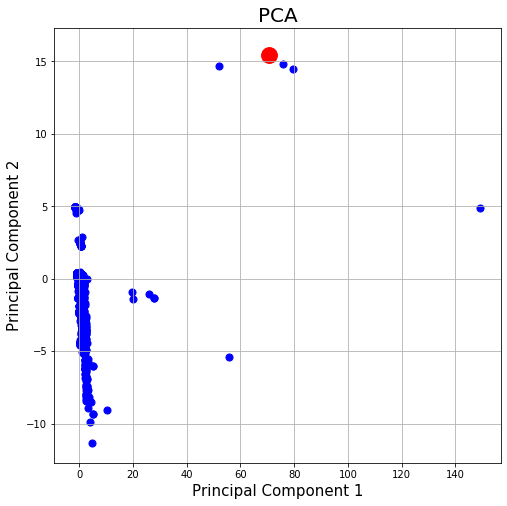

In [13]:
dns_pca = PCA_on_data(df_dns)
dns_pca.loc[dns_pca.p1>40]

In [14]:
# all PCA "outlier" points seem to have time_elapsed_sec ~ 90 
# but this can happen for the "non outlier" points as well..
df_dns.iloc[dns_pca.loc[dns_pca.p1>40].index, :]

,index,source_port,dest_port,nat_source_port,nat_dest_port,bytes,bytes_sent,bytes_received,packets,time_elapsed_sec,timestamp,ts_ret_a,timestamp_relative,packets_sent,packets_received
2010,8199,21447,53,34557,53,80280,68084,12196,889,90,1552585353408,11553408,481392,816,73
2084,8634,21447,53,55331,53,245648,213726,31922,2763,89,1552585804128,12004128,500172,2579,184
5671,22619,35047,53,40543,53,214830,214584,246,2594,88,1552606404696,32604696,1358529,2591,3
8866,35198,26081,53,4535,53,243667,236247,7420,2897,90,1552625587176,51787176,2157799,2851,46
12115,47966,33409,53,6047,53,241272,234761,6511,2872,89,1552649657616,75857616,3160734,2833,39
14749,60540,8430,53,61822,53,239209,233954,5255,2850,88,1552669400640,95600640,3983360,2822,28
17852,76036,8430,53,61822,53,239209,233954,5255,28500,88,1552695187200,95600640,3983360,2822,28


In [15]:
# unique source ports are about 36% of entire dns df
len(df_dns.source_port.unique())/df_dns.shape[0]

0.36296420769618554

In [16]:
# not sure what to do with these... will regard them as normal
#are those attacks of a different kind? errors? normal behavior? google wasn't too helpful...
df_dns.loc[df_dns.nat_source_port==0]

,index,source_port,dest_port,nat_source_port,nat_dest_port,bytes,bytes_sent,bytes_received,packets,time_elapsed_sec,timestamp,ts_ret_a,timestamp_relative,packets_sent,packets_received
49,323,52852,53,0,0,82,82,0,1,30,1552574146344,346344,14431,1,0
139,813,47009,53,0,0,86,86,0,1,30,1552575082032,1282032,53418,1,0
179,1085,36712,53,0,0,138,69,69,2,30,1552575555264,1755264,73136,1,1
180,1096,38400,53,0,0,82,82,0,1,30,1552575564912,1764912,73538,1,0
188,1113,41774,53,0,0,82,82,0,1,30,1552575575496,1775496,73979,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17791,75653,58429,53,0,0,360,160,200,4,49,1552694640480,95053920,3960580,2,2
17805,75691,40890,53,0,0,86,86,0,1,30,1552694725296,95138736,3964114,1,0
17811,75711,49308,53,0,0,627,80,547,2,29,1552694749752,95163192,3965133,1,1
17819,75731,41858,53,0,0,86,86,0,1,30,1552694790576,95204016,3966834,1,0


np.diff(df_dns.timestamp)


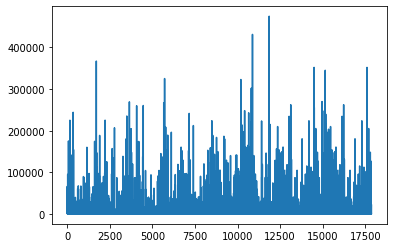

packets_sent


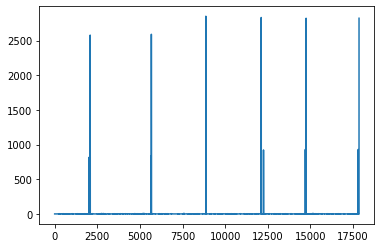

bytes


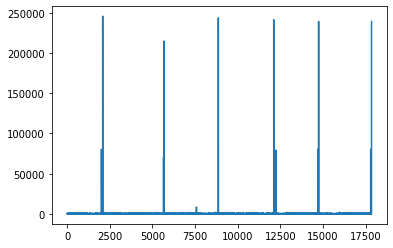

In [17]:
# seems like there is seasonality in the times between each row
# not sure how to utilize this info right now
print("np.diff(df_dns.timestamp)")
plt.plot(np.diff(df_dns.timestamp))
plt.show()

# obvious repeating behavior and obvious anomaly when looking at packets / packets_sent
print("packets_sent")
plt.plot(df_dns.packets_sent)
plt.show()

# obvious repeating behavior and obvious anomaly when looking at bytes
print("bytes")
plt.plot(df_dns.bytes)
plt.show()

# will try to detect the peaks

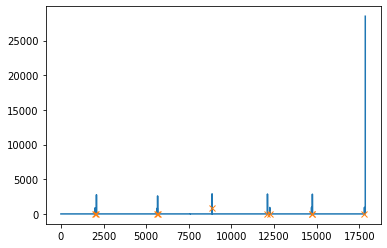

DBSCAN


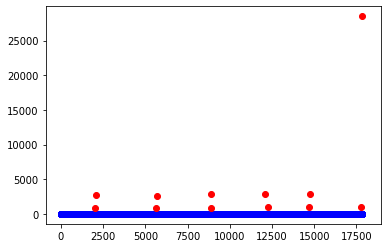

zscore


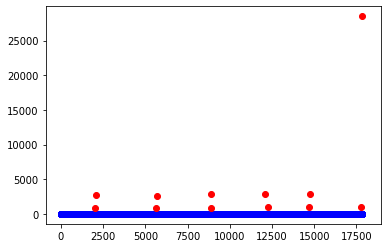

In [19]:
# can identify anomalies with "scipy find_peaks" and DBSCAN but simpler and safer with z score
from scipy.signal import find_peaks
from scipy import stats

X = df_dns.loc[:,['packets']].values.reshape(-1)
peaks, _ = find_peaks(np.diff(X), height=100)
plt.plot(X)
plt.plot(peaks, X[peaks], "x")
plt.show()

from sklearn.cluster import DBSCAN
#df_dns = df_dns.loc[df_dns.nat_source_port!=0]
X = df_dns.loc[:,['packets']].values#.reshape(-1, 1)
#scaler = StandardScaler()
#X = scaler.fit_transform(X)
clf = DBSCAN(eps=int(np.mean(X)*5)).fit(X)

df_dns['cluster'] = clf.labels_
print("DBSCAN")
plt.scatter(df_dns[df_dns.cluster!=-1].index, df_dns[df_dns.cluster!=-1].packets, c='b')
plt.scatter(df_dns.loc[df_dns.cluster==-1].index, df_dns.loc[df_dns.cluster==-1].packets,c='r')
plt.show()

# choose spikes to be > 3 std
z = np.abs(stats.zscore(df_dns.packets.values.reshape(-1)))
df_dns['z'] = z
thresh = 3
print("zscore")
plt.scatter(df_dns[df_dns.z<=thresh].index, df_dns[df_dns.z<=thresh].packets, c='b')
plt.scatter(df_dns.loc[df_dns.z>thresh].index, df_dns.loc[df_dns.z>thresh].packets,c='r')
plt.show()

In [20]:
# pretty consistent time intervals between high spikes - printed in minutes
#going to identify the spikes using z score
from scipy import stats
from sklearn.cluster import KMeans


def find_indexes_of_spikes(data, thtresh=3):
    indexes_of_spikes = (data.z>thresh)
    #indexes_of_spikes.iloc[0] = True
    time_intervals = (np.diff(data.loc[indexes_of_spikes].timestamp)/60000).reshape(-1, 1)

    #spikes have small and large gaps so will cluster them to 2 groups using KMEANS
    time_clusters = KMeans(n_clusters=2, random_state=0).fit(time_intervals).labels_
    print("mean time interval in minutes: ", np.mean(time_intervals[time_clusters==0]), np.mean(time_intervals[time_clusters==1]))
    print("std time interval in minutes: ", np.std(time_intervals[time_clusters==0]), np.std(time_intervals[time_clusters==1]))

    #choose the one with the larger mean:
    choose_0 = np.mean(time_intervals[time_clusters==0]) > np.mean(time_intervals[time_clusters==1])
    if choose_0:
        big_time_interval = time_intervals[time_clusters==0] * 60000
        small_time_interval = time_intervals[time_clusters==1] * 60000
    else:
        big_time_interval = time_intervals[time_clusters==1] * 60000
        small_time_interval = time_intervals[time_clusters==0] * 60000                    
                             
    return indexes_of_spikes, big_time_interval, small_time_interval

indexes_of_spikes, time_clusters, _ = find_indexes_of_spikes(df_dns)

mean time interval in minutes:  358.62792 6.237266666666666
std time interval in minutes:  44.9703389865987 4.2450512579028095


In [21]:
# calculate boundries of time range and spike values with confidence interval
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), stats.sem(a)
    h = se * stats.t.ppf((1 + confidence) / 2., n-1)
    return m-h, m+h

min_time, max_time = mean_confidence_interval(time_clusters)
print("min_time, max_time: ", min_time, max_time)

_, max_spike = mean_confidence_interval(df_dns.loc[indexes_of_spikes].packets.values)
print("max_spike: ", max_spike)

min_time, max_time:  [17771944.87324717] [25263405.52675283]
max_spike:  8934.686166911288


# from the EDA: the purposed steps for identifying an anomaly with dest_port=53:
1. check if packets != packets_sent + packets_received : easy (should be checked for any port really)
2. check if packets or packets_sent is higher than expected value - depending on timestamp

use a configurable confidence interval to decide if point is an anomaly

In [22]:
#split data to train and test by keeping last 10% of rows
partition = int(0.9 * df_dns.shape[0])
train_df = df_dns.iloc[:partition,:].copy()
test_df = df_dns.iloc[partition:,:].copy()

In [24]:
# calculate normal ranges for time gaps and spike height
z = np.abs(stats.zscore(train_df.packets.values.reshape(-1)))
train_df['z'] = z

indexes_of_spikes, time_clusters, _ = find_indexes_of_spikes(train_df)

min_time, max_time = mean_confidence_interval(time_clusters)
print("min_time, max_time: ", min_time, max_time)

_, max_spike = mean_confidence_interval(train_df.loc[indexes_of_spikes].packets.values)
print("max_spike: ", max_spike)

mean time interval in minutes:  342.8205 5.901039999999999
std time interval in minutes:  35.75670007746799 4.576708641633199
min_time, max_time:  [16627297.89661958] [24511162.10338042]
max_spike:  2565.3093470157346


In [25]:
# find last non anomalous spike
ts_of_last_spike = train_df.loc[indexes_of_spikes[indexes_of_spikes].index[-1]].timestamp
print("ts_of_last_spike: ", ts_of_last_spike)

ts_of_last_spike:  1552669400640.0


In [26]:
# running on all test rows: only anomaly identified is the real known anomaly
for idx, row in test_df.iterrows():
    # check if numer of packets is consistent:
    if row.packets != row.packets_sent + row.packets_received:
        print(idx)
    #check if there is a spike:
    if row.packets > max_spike:
        #check if spike outside learned range:
        if row.timestamp - ts_of_last_spike > max_time or row.timestamp - ts_of_last_spike > min_time:
            print(idx)

17852
17852


In [27]:
test_df.loc[17852,:] == anomaly 

,bytes,bytes_received,bytes_sent,cluster,dest_port,index,nat_dest_port,nat_source_port,packets,packets_received,packets_sent,source_port,time_elapsed_sec,timestamp,timestamp_relative,ts_ret_a,z
76036,True,True,True,False,True,False,True,True,True,True,True,True,True,True,True,True,False
